In [7]:
!pip -q install torch torchtext torchmetrics scikit-learn matplotlib pandas nltk


Legal Clause Similarity – Baseline Models (BiLSTM & Attention Encoder)

In [8]:
# ==========================================================
# 📦 SETUP
# ==========================================================
import os, random, re, gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # <-- add this line

from nltk.tokenize import word_tokenize
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# ==========================================================
# 📂 LOAD DATA FROM DRIVE
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/datasetdeepassignment2"

dfs = []
for f in os.listdir(DATA_DIR):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join(DATA_DIR, f))
        df = df.rename(columns={'clause_text':'text', 'clause_type':'label'})
        df['source'] = f
        dfs.append(df[['text','label','source']])

data = pd.concat(dfs, ignore_index=True).dropna(subset=['text','label'])
data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(f"Loaded {len(data)} clauses from {data['source'].nunique()} files")
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 150881 clauses from 395 files


,text,label,source
0,Definitions. 1. For the purposes of this Agree...,definitions,definitions.csv
1,Costs and Expenses. The Borrowers shall pay (i...,costs-and-expenses,costs-and-expenses.csv
2,Registration Expenses. Subject to Section 10(l):,registration-expenses,registration-expenses.csv
3,Exclusions. Confidential Information shall not...,exclusions,exclusions.csv
4,Representations. The representations of the Bo...,representations,representations.csv


In [17]:
# ==========================================================
# 🧹 PREPROCESSING & TOKENIZATION
# ==========================================================
def preprocess(s: str):
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return word_tokenize(s)

tokens_list = [preprocess(t) for t in data['text'].tolist()]

# Build capped vocab
min_freq, max_vocab = 2, 50000
freq = Counter([tok for toks in tokens_list for tok in toks])
most_common = [w for w, c in freq.items() if c >= min_freq][:max_vocab - 4]
stoi = {w: i + 4 for i, w in enumerate(most_common)}
stoi.update({'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3})
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

def encode(tokens, max_len=128):
    ids = [stoi['<bos>']] + [stoi.get(t, stoi['<unk>']) for t in tokens][:max_len - 2] + [stoi['<eos>']]
    return torch.tensor(ids, dtype=torch.long)

encoded = [encode(toks, max_len=128) for toks in tokens_list]
labels = data['label'].astype(str).tolist()

# Build label2idx
label2idx = defaultdict(list)
for i, y in enumerate(labels):
    label2idx[y].append(i)
unique_labels = list(label2idx.keys())
print("Num labels:", len(unique_labels))


Vocab size: 33613
Num labels: 395


In [10]:
# ==========================================================
# 🎲 ON-THE-FLY PAIR DATASET
# ==========================================================
class PairDataset(Dataset):
    def __init__(self, encoded, labels, label2idx, num_pairs=60000, pos_ratio=0.5):
        self.encoded, self.labels, self.label2idx = encoded, labels, label2idx
        self.num_pairs, self.pos_ratio = num_pairs, pos_ratio
        self.label_keys = list(label2idx.keys())

    def __len__(self):
        return self.num_pairs

    def _sample_pos(self):
        y = random.choice([k for k, v in self.label2idx.items() if len(v) > 1])
        i, j = random.sample(self.label2idx[y], 2)
        return i, j, 1.0

    def _sample_neg(self):
        y1, y2 = random.sample(self.label_keys, 2)
        i = random.choice(self.label2idx[y1])
        j = random.choice(self.label2idx[y2])
        return i, j, 0.0

    def __getitem__(self, _):
        if random.random() < self.pos_ratio:
            i, j, lbl = self._sample_pos()
        else:
            i, j, lbl = self._sample_neg()
        return self.encoded[i], self.encoded[j], torch.tensor(lbl, dtype=torch.float32)

def collate_pairs(batch):
    from torch.nn.utils.rnn import pad_sequence
    s1, s2, y = zip(*batch)
    return (pad_sequence(s1, batch_first=True, padding_value=0),
            pad_sequence(s2, batch_first=True, padding_value=0),
            torch.stack(y))


In [11]:
# ==========================================================
# 🧭 TRAIN/VAL SPLIT
# ==========================================================
idx_train, idx_val = train_test_split(range(len(encoded)), test_size=0.2, random_state=42, stratify=labels)

train_label2idx = defaultdict(list)
val_label2idx = defaultdict(list)
for i in idx_train: train_label2idx[labels[i]].append(i)
for i in idx_val:   val_label2idx[labels[i]].append(i)

train_ds = PairDataset(encoded, labels, train_label2idx, num_pairs=60000)
val_ds   = PairDataset(encoded, labels, val_label2idx,   num_pairs=15000)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, collate_fn=collate_pairs)


In [12]:
# ==========================================================
# 🧩 MODELS
# ==========================================================
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*4, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, s1, s2):
        _, (h1, _) = self.lstm(self.embed(s1))
        _, (h2, _) = self.lstm(self.embed(s2))
        h = torch.cat([h1[-1], h2[-1], torch.abs(h1[-1]-h2[-1]), h1[-1]*h2[-1]], dim=1)
        return self.fc(h)

class AttentionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim*4, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, s1, s2):
        e1, e2 = self.embed(s1), self.embed(s2)
        attn1, _ = self.attn(e1, e1, e1)
        attn2, _ = self.attn(e2, e2, e2)
        v1, v2 = attn1.mean(dim=1), attn2.mean(dim=1)
        h = torch.cat([v1, v2, torch.abs(v1-v2), v1*v2], dim=1)
        return self.fc(h)


In [13]:
# ==========================================================
# ⚙️ TRAINING FUNCTION
# ==========================================================
def train_model(model, train_loader, val_loader, epochs=6, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    train_losses, val_accs = [], []
    for ep in range(epochs):
        model.train()
        epoch_loss = 0
        for s1, s2, y in train_loader:
            s1, s2, y = s1.to(device), s2.to(device), y.to(device)
            opt.zero_grad()
            out = model(s1, s2).squeeze()
            loss = crit(out, y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for s1, s2, y in val_loader:
                s1, s2 = s1.to(device), s2.to(device)
                out = model(s1, s2).squeeze().cpu().numpy()
                preds.extend((out > 0.5).astype(int))
                trues.extend(y.numpy())
        acc = accuracy_score(trues, preds)
        val_accs.append(acc)
        print(f"Epoch {ep+1}/{epochs} | Loss={train_losses[-1]:.4f} | ValAcc={acc:.4f}")

    return train_losses, val_accs, model


In [14]:
# ==========================================================
# 🚀 TRAIN BOTH MODELS
# ==========================================================
bilstm = BiLSTMModel(vocab_size)
attn   = AttentionEncoder(vocab_size)

print("Training BiLSTM...")
bilstm_loss, bilstm_acc, bilstm = train_model(bilstm, train_loader, val_loader)

print("\nTraining Attention Encoder...")
attn_loss, attn_acc, attn = train_model(attn, train_loader, val_loader)


Training BiLSTM...
Epoch 1/6 | Loss=0.0160 | ValAcc=0.9994
Epoch 2/6 | Loss=0.0023 | ValAcc=0.9989
Epoch 3/6 | Loss=0.0016 | ValAcc=0.9998
Epoch 4/6 | Loss=0.0006 | ValAcc=0.9997
Epoch 5/6 | Loss=0.0010 | ValAcc=0.9999
Epoch 6/6 | Loss=0.0005 | ValAcc=0.9998

Training Attention Encoder...
Epoch 1/6 | Loss=0.4668 | ValAcc=0.8721
Epoch 2/6 | Loss=0.2630 | ValAcc=0.9142
Epoch 3/6 | Loss=0.1907 | ValAcc=0.9349
Epoch 4/6 | Loss=0.1538 | ValAcc=0.9390
Epoch 5/6 | Loss=0.1424 | ValAcc=0.9513
Epoch 6/6 | Loss=0.1250 | ValAcc=0.9531



📈 BiLSTM Metrics
Accuracy:  0.9995
Precision: 0.9996
Recall:    0.9995
F1-score:  0.9995
ROC-AUC:   1.0000


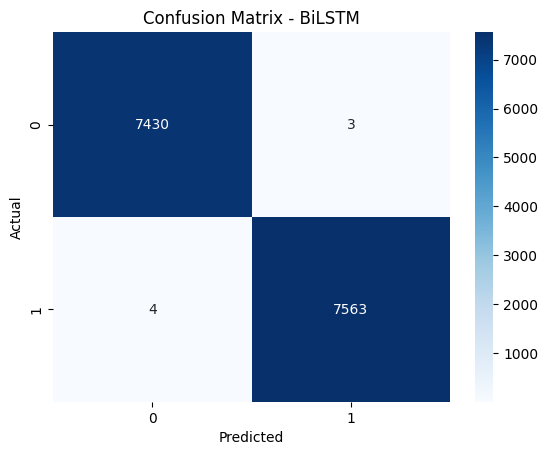


📈 Attention Encoder Metrics
Accuracy:  0.9549
Precision: 0.9589
Recall:    0.9491
F1-score:  0.9540
ROC-AUC:   0.9896


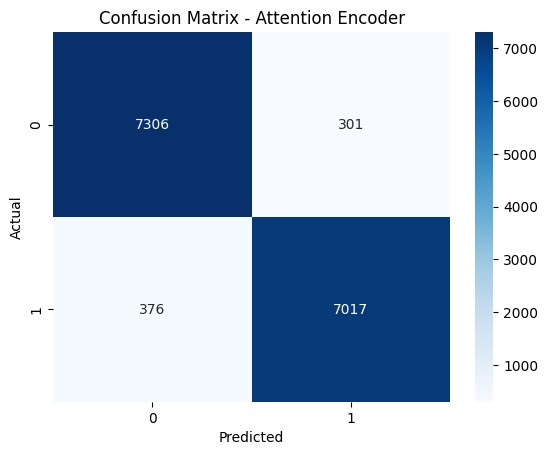

In [15]:
# ==========================================================
# 📊 METRICS & CONFUSION MATRIX
# ==========================================================
def evaluate_model(model, val_loader):
    model.eval()
    preds, probs, trues = [], [], []
    with torch.no_grad():
        for s1, s2, y in val_loader:
            s1, s2 = s1.to(device), s2.to(device)
            out = model(s1, s2).squeeze().cpu().numpy()
            probs.extend(out)
            preds.extend((out > 0.5).astype(int))
            trues.extend(y.numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    auc = roc_auc_score(trues, probs)
    cm = confusion_matrix(trues, preds)
    return acc, prec, rec, f1, auc, cm, preds, trues

def display_metrics(name, metrics):
    acc, prec, rec, f1, auc, cm, _, _ = metrics
    print(f"\n📈 {name} Metrics")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

bilstm_metrics = evaluate_model(bilstm, val_loader)
attn_metrics   = evaluate_model(attn, val_loader)

display_metrics("BiLSTM", bilstm_metrics)
display_metrics("Attention Encoder", attn_metrics)


In [16]:
# ==========================================================
# ✅ QUALITATIVE ANALYSIS
# ==========================================================
def show_examples(model, val_loader, k=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for s1, s2, y in val_loader:
            s1, s2 = s1.to(device), s2.to(device)
            out = model(s1, s2).squeeze().cpu().numpy()
            preds = (out > 0.5).astype(int)
            for i in range(len(preds)):
                if preds[i] == y[i].item() and shown < k:
                    print(f"\n✅ Correct | True={int(y[i].item())}, Pred={preds[i]}")
                    print("Clause1:", " ".join([itos[x.item()] for x in s1[i] if x.item()>3]))
                    print("Clause2:", " ".join([itos[x.item()] for x in s2[i] if x.item()>3]))
                    shown += 1
                elif preds[i] != y[i].item() and shown < k:
                    print(f"\n❌ Wrong | True={int(y[i].item())}, Pred={preds[i]}")
                    print("Clause1:", " ".join([itos[x.item()] for x in s1[i] if x.item()>3]))
                    print("Clause2:", " ".join([itos[x.item()] for x in s2[i] if x.item()>3]))
                    shown += 1
                if shown >= k: return

print("\n=== BiLSTM Examples ===")
show_examples(bilstm, val_loader, k=5)

print("\n=== Attention Encoder Examples ===")
show_examples(attn, val_loader, k=5)



=== BiLSTM Examples ===

✅ Correct | True=0, Pred=0
Clause1: governing law and jurisdiction . this agreement and performance hereunder and all suits and proceedings hereunder shall be governed by and construed in accordance with the internal laws of the commonwealth of pennsylvania , without giving effect to conflict of law principles . each of the parties to this agreement expressly and irrevocably submits to the exclusive jurisdiction of the courts of pennsylvania and waives any claims of inconvenient forum or venue . to the extent that the laws of the commonwealth of pennsylvania conflict with the applicable provisions of the 1940 act , the applicable provisions of the 1940 act shall control .
Clause2: publicity . the award of this contract to contractor is not in any way an endorsement of contractor or contractor ’ s services by hca and must not be so construed by contractor in any advertising or other publicity materials .

✅ Correct | True=1, Pred=1
Clause1: acceleration . accel